_Importing Required Libraries_

In [1]:
pip install hampel

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: pandas in c:\users\anurag dutta\appdata\local\packages\pythonsoftwarefoundation.python.3.9_qbz5n2kfra8p0\localcache\local-packages\python39\site-packages (from hampel) (1.5.2)




[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Anurag Dutta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from matplotlib import pyplot
from numpy import array

## Pretraining

The `capa_intermittency.dat` feeds the model with the dynamics of the Capacitor

In [3]:
data = np.genfromtxt('capa_intermittency.dat')
training_set = pd.DataFrame(data).reset_index(drop=True)
training_set = training_set.iloc[:,0]

## Computing the Gradient

_Calculating the value of_ $\frac{dx}{dt}$

In [4]:
t_diff = 1
print(training_set.max())
gradient_t = (training_set.diff()/t_diff).iloc[1:] # dx/dt
print(gradient_t)

1.0
1        0.000298
2        0.000298
3        0.000297
4        0.000297
5        0.000297
           ...   
9996     0.000018
9997     0.000018
9998     0.000018
9999     0.000018
10000    0.000018
Name: 0, Length: 10000, dtype: float64


## Loading Datasets

In [5]:
data = pd.read_csv("c3_interpolated_2450_50.csv")
training_set = data.iloc[:, 1]
training_set

0       91.100000
1       90.875910
2       90.651821
3       90.427731
4       90.203641
          ...    
2495    67.025142
2496    67.018856
2497    67.012571
2498    67.006285
2499    67.000000
Name: C3, Length: 2500, dtype: float64

In [6]:
test = training_set.tail(50)
test
training_set = training_set.head(2450)
training_set

0       91.100000
1       90.875910
2       90.651821
3       90.427731
4       90.203641
          ...    
2445     0.000000
2446     0.000000
2447     0.000000
2448     0.033660
2449     0.000000
Name: C3, Length: 2450, dtype: float64

In [7]:
training_set = training_set.reset_index(drop=True)
gradient_t = gradient_t.reset_index(drop=True)
print(gradient_t)

0       0.000298
1       0.000298
2       0.000297
3       0.000297
4       0.000297
          ...   
9995    0.000018
9996    0.000018
9997    0.000018
9998    0.000018
9999    0.000018
Name: 0, Length: 10000, dtype: float64


In [8]:
df = pd.concat((training_set, gradient_t), axis=1)
df.columns = ['y_t', 'grad_t']

In [9]:
df

,y_t,grad_t
0,91.100000,0.000298
1,90.875910,0.000298
2,90.651821,0.000297
3,90.427731,0.000297
4,90.203641,0.000297
...,...,...
9995,NaN,0.000018
9996,NaN,0.000018
9997,NaN,0.000018
9998,NaN,0.000018


## Plot of the External Forcing from Chaotic Differential Equation

<Axes: >

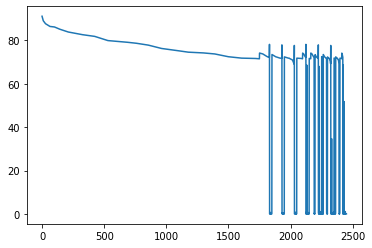

In [10]:
df.iloc[:, 0].plot()

C:\Users\Anurag Dutta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: >

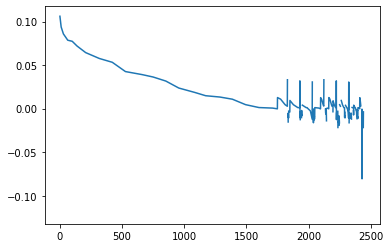

In [11]:
import numpy as np
c0 = 88.0403  # Value for C0
K0 = -0.0012  # Value for K0
K1 = -0.0001  # Value for K1
a = 0.0000    # Value for a
b = 0.0120    # Value for b
c = 2.0334    # Value for c

L = np.minimum(c0, (df.iloc[:, 1] - (df.iloc[:, 0] * (K0 - K1 * (9 * a * np.log(df.iloc[:, 0] / c0) / (K0 - K1 * c)**2 + 4 * b * np.log(df.iloc[:, 0] / c0) / (K0 - K1 * c) + c)))))
L.plot()

## Preprocessing the data into supervised learning

In [12]:
# split a sequence into samples
def Supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n_in, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n_out)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
       agg.dropna(inplace=True)
    return agg

In [13]:
data = Supervised(df.values, n_in = 175, n_out = 50)


cols_to_drop = []
for i in range(2, 176):
    cols_to_drop.extend([f'var2(t-{i})'])

data.drop(cols_to_drop, axis=1, inplace=True)

print(data.head())
print(data.columns)

     var1(t-175)  var1(t-174)  var1(t-173)  var1(t-172)  var1(t-171)  \
175    91.100000    90.875910    90.651821    90.427731    90.203641   
176    90.875910    90.651821    90.427731    90.203641    89.979552   
177    90.651821    90.427731    90.203641    89.979552    89.755462   
178    90.427731    90.203641    89.979552    89.755462    89.531373   
179    90.203641    89.979552    89.755462    89.531373    89.307283   

     var1(t-170)  var1(t-169)  var1(t-168)  var1(t-167)  var1(t-166)  ...  \
175    89.979552    89.755462    89.531373    89.307283    89.094118  ...   
176    89.755462    89.531373    89.307283    89.094118    89.015686  ...   
177    89.531373    89.307283    89.094118    89.015686    88.937255  ...   
178    89.307283    89.094118    89.015686    88.937255    88.858824  ...   
179    89.094118    89.015686    88.937255    88.858824    88.780392  ...   

     var1(t+45)  var2(t+45)  var1(t+46)  var2(t+46)  var1(t+47)  var2(t+47)  \
175   83.735014    0.0002

In [14]:
train = np.array(data[0:len(data)-1])
forecast = np.array(data.tail(1))

In [15]:
trainy = train[:,-150:]
trainX = train[:,:-150]

In [16]:
forecasty = forecast[:,-150:]
forecastX = forecast[:,:-150]

In [17]:
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
forecastX = forecastX.reshape((forecastX.shape[0], 1, forecastX.shape[1]))
print(trainX.shape, trainy.shape, forecastX.shape)

(2225, 1, 126) (2225, 150) (1, 1, 126)


In [18]:
C0 = tf.Variable(88.0403, name="C0", trainable=True, dtype=tf.float32)
K0 = tf.Variable(-0.0012, name="K0", trainable=True, dtype=tf.float32)
K1 = tf.Variable(-0.0001, name="K1", trainable=True, dtype=tf.float32)
a = tf.Variable(0.0000, name="a", trainable=True, dtype=tf.float32)
b = tf.Variable(0.0120, name="b", trainable=True, dtype=tf.float32)
c = tf.Variable(2.0334, name="c", trainable=True, dtype=tf.float32)

splitr = 0.8


def loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true[:, 0] - y_pred[:, 0])
    #squared_difference2 = tf.square(y_true[:, 2]-y_pred[:, 2])
    #squared_difference1 = tf.square(y_true[:, 1]-y_pred[:, 1])
    epsilon = 1
    squared_difference3 = tf.square(
        y_pred[:, 1] - (
            y_pred[:, 0] * (
                K0 - K1 * (
                    9 * a * tf.math.log((y_pred[:, 0] + epsilon) / C0) / (K0 - K1 * c)**2 +
                    4 * b * tf.math.log((y_pred[:, 0] + epsilon) / C0) / (K0 - K1 * c) + c
                )
            )
        )
    )
    return tf.reduce_mean(squared_difference, axis=-1) + 0.2*tf.reduce_mean(squared_difference3, axis=-1)
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(60))
model.compile(loss=loss_fn, optimizer='adam')
history = model.fit(trainX[:int(splitr*trainX.shape[0])], trainy[:int(splitr*trainX.shape[0])], epochs=500, batch_size=64, validation_data=(trainX[int(splitr*trainX.shape[0]):trainX.shape[0]], trainy[int(splitr*trainX.shape[0]):trainX.shape[0]]), shuffle=False)

Epoch 1/500
28/28 [==============================] - 2s 19ms/step - loss: 5552.4751 - val_loss: 3424.7124
Epoch 2/500
28/28 [==============================] - 0s 5ms/step - loss: 5303.2188 - val_loss: 3218.4119
Epoch 3/500
28/28 [==============================] - 0s 4ms/step - loss: 5052.6943 - val_loss: 3084.5444
Epoch 4/500
28/28 [==============================] - 0s 4ms/step - loss: 4866.0791 - val_loss: 2966.8926
Epoch 5/500
28/28 [==============================] - 0s 4ms/step - loss: 4692.7314 - val_loss: 2868.1118
Epoch 6/500
28/28 [==============================] - 0s 4ms/step - loss: 4533.7329 - val_loss: 2775.9363
Epoch 7/500
28/28 [==============================] - 0s 6ms/step - loss: 4382.5264 - val_loss: 2688.4202
Epoch 8/500
28/28 [==============================] - 0s 4ms/step - loss: 4237.2578 - val_loss: 2604.7578
Epoch 9/500
28/28 [==============================] - 0s 3ms/step - loss: 4093.5583 - val_loss: 2520.6743
Epoch 10/500
28/28 [==============================] - 

In [19]:
forecast_without_mc = forecastX
yhat_without_mc = model.predict(forecast_without_mc) # Step Ahead Prediction
forecast_without_mc = forecast_without_mc.reshape((forecast_without_mc.shape[0], forecast_without_mc.shape[2])) # Historical Input

1/1 [==============================] - 0s 375ms/step


In [20]:
forecastX.shape

(1, 1, 126)

In [21]:
forecast_without_mc.shape

(1, 126)

In [22]:
inv_yhat_without_mc = np.concatenate((forecast_without_mc, yhat_without_mc), axis=1) # Concatenation of predicted values with Historical Data
#inv_yhat_without_mc = scaler.inverse_transform(inv_yhat_without_mc) # Transform labels back to original encoding

In [23]:
inv_yhat_without_mc.shape

(1, 186)

In [24]:
fforecast = inv_yhat_without_mc[:,-150:]

In [25]:
fforecast.shape

(1, 150)

In [26]:
final_forecast = fforecast[:,0:150:3]

In [27]:
fforecast.shape

(1, 150)

In [28]:
# code to replace all negative value with 0
final_forecast[final_forecast<0] = 0

In [29]:
final_forecast

array([[0.00000000e+00, 7.33543880e+01, 7.30277078e+01, 7.26999767e+01,
        7.24312092e+01, 7.22547386e+01, 7.20782680e+01, 7.19017974e+01,
        7.17893324e+01, 7.17641223e+01, 1.47510827e-01, 4.24880058e-01,
        7.23266340e+01, 7.21501634e+01, 7.19736928e+01, 7.17996032e+01,
        7.17743931e+01, 7.14918300e+01, 7.12397290e+01, 7.10938142e+01,
        6.96776380e+01, 4.20036280e-02, 1.45638764e-01, 3.46528587e+01,
        2.25153655e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        5.13487697e-01, 0.00000000e+00, 4.99015312e+01, 2.81719685e-01,
        3.71721298e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 8.93081367e-01, 0.00000000e+00,
        3.34201008e-01, 2.79544622e-01, 8.55977595e-01, 4.21371549e-01,
        1.59168541e-01, 0.00000000e+00, 9.46579397e-01, 0.00000000e+00,
        0.00000000e+00, 3.26286614e-01]])

In [30]:
final_forecast.shape

(1, 50)

In [31]:
test.shape

(50,)

In [32]:
training_set = np.array(training_set)
test = np.array(test)
final_forecast = np.array(final_forecast.squeeze(0))

In [33]:
test

array([67.30798661, 67.30170117, 67.29541573, 67.28913029, 67.28284485,
       67.2765594 , 67.27027396, 67.26398852, 67.25770308, 67.25141764,
       67.2451322 , 67.23884676, 67.23256132, 67.22627588, 67.21999044,
       67.21370499, 67.20741955, 67.20113411, 67.19484867, 67.18856323,
       67.18227779, 67.17599235, 67.16970691, 67.16342147, 67.15713603,
       67.15085058, 67.14456514, 67.1382797 , 67.13199426, 67.12570882,
       67.11942338, 67.11313794, 67.1068525 , 67.10056706, 67.09428162,
       67.08799617, 67.08171073, 67.07542529, 67.06913985, 67.06285441,
       67.05656897, 67.05028353, 67.04399809, 67.03771265, 67.03142721,
       67.02514176, 67.01885632, 67.01257088, 67.00628544, 67.        ])

In [34]:
test.shape

(50,)

In [35]:
final_forecast.shape

(50,)

In [36]:
test.shape

(50,)

In [37]:
import math
MSE = np.square(np.subtract(np.array(test),np.array(final_forecast))).mean()   
rsme = math.sqrt(MSE)
print(rsme)  
MAE = np.abs(np.subtract(np.array(test),np.array(final_forecast))).mean()   
mae = MAE
print(mae)

52.151673701705164
42.81788731772587
